# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs! 

In this document you will work through a similar process that we did in class with the NBA data files will be in the Canvas assignment, merging them together.

Details: 

- Determine a way to use clustering to estimate based on performance if 
players are under or over paid, generally. 

- Then select players you believe would be best for your team and explain why. Do so in three categories: 
    * Examples that are not good choices (3 or 4) 
    * Several options that are good choices (3 or 4)
    * Several options that could work, assuming you can't get the players in the good category (3 or 4)

- You will decide the cutoffs for each category, so you should be able to explain why you chose them.

- Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations. 


Hints:

- Salary is the variable you are trying to understand 
- When interpreting you might want to use graphs that include variables that are the most correlated with Salary
- You'll need to scale the variables before performing the clustering
- Be specific about why you selected the players that you did, more detail is better
- Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used. 
- Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load datasets
salary_data = pd.read_csv("2025_salaries.csv", header=1, encoding="latin-1")
stats = pd.read_csv("nba_2025.txt", sep=",", encoding="latin-1")

# Rename salary column for clarity
salary_data = salary_data.rename(columns={"2025-26": "Salary"})

# Merge datasets
merged_data = pd.merge(salary_data, stats, on="Player")

In [2]:
# Drop variables that will not be needed or are duplicates

# Remove duplicate players, keep the one with most games played
merged_data = merged_data.sort_values("G", ascending=False)
merged_data = merged_data.drop_duplicates(subset="Player", keep="first")

# Keep only relevant columns
df = merged_data[["Player", "Salary", "G", "MP", "PTS"]].copy()
df.head()

,Player,Salary,G,MP,PTS
455,Julius Randle,"$30,864,198",56.0,1882.0,1251.0
65,Toumani Camara,"$2,221,677",56.0,1873.0,734.0
357,Donte DiVincenzo,"$11,990,000",56.0,1745.0,716.0
429,DeMar DeRozan,"$24,570,000",56.0,1813.0,1047.0
420,Naz Reid,"$21,551,724",56.0,1468.0,793.0


In [3]:
# Clean salary column
df["Salary"] = (
    df["Salary"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
)
df["Salary"] = pd.to_numeric(df["Salary"], errors="coerce")

# Drop any rows with missing values
df = df.dropna(subset=["Salary", "G", "MP", "PTS"])

# Separate salary & players
salary = df["Salary"].copy()
players = df["Player"].copy()

# Feature matrix (numeric only)
X = df[["G", "MP", "PTS"]].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Run the clustering algo with your best guess for K

# KMeans model with k=3 (three performance tiers)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Attach clusters
df["Cluster"] = kmeans.predict(X_scaled)

# Relabel clusters by performance (average points)
cluster_means = df.groupby("Cluster")["PTS"].mean().sort_values()
cluster_map = {old: new for new, old in enumerate(cluster_means.index)}
df["Cluster"] = df["Cluster"].map(cluster_map)

In [5]:
# View the results

# Cluster sizes 
print("Cluster Counts:")
print(df["Cluster"].value_counts().sort_index())

# Model inertia
print("\nModel Inertia:")
print(kmeans.inertia_)

# Cluster averages 
print("\nCluster Performance Averages:")
cluster_summary = df.groupby("Cluster").mean(numeric_only=True)
print(cluster_summary)

Cluster Counts:
Cluster
0     99
1    174
2    138
Name: count, dtype: int64

Model Inertia:
288.84015065375934

Cluster Performance Averages:
               Salary          G           MP         PTS
Cluster                                                  
0        7.708677e+06  17.464646   218.484848   89.616162
1        8.460904e+06  40.804598   786.287356  309.005747
2        2.035631e+07  48.978261  1454.442029  803.478261


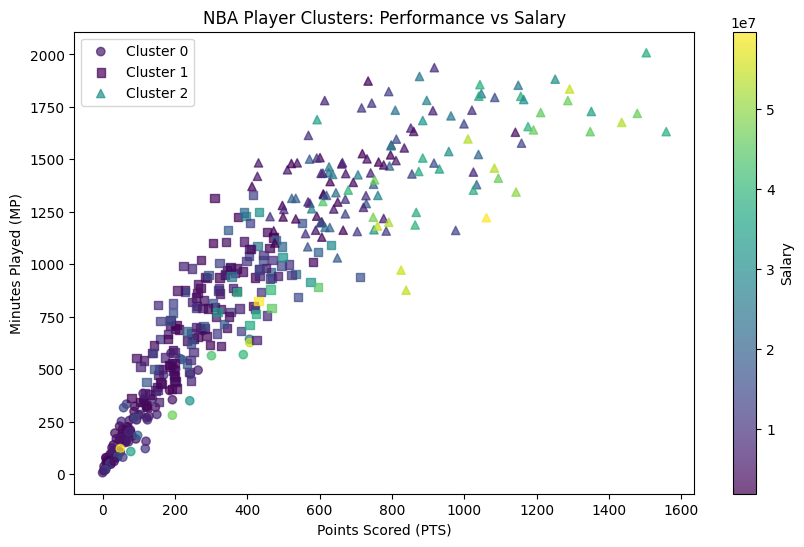

In [14]:
# Create a visualization of the results with 2 or 3 variables that you think will best differentiate the clusters

# Create scatter plot
plt.figure(figsize=(10,6))

# Unique clusters, sorted
clusters = sorted(df["Cluster"].unique())

markers = ['o', 's', '^']  # different shapes for clusters

for cluster, marker in zip(clusters, markers):
    subset = df[df["Cluster"] == cluster]
    
    scatter = plt.scatter(
        subset["PTS"], 
        subset["MP"], 
        c=subset["Salary"], 
        cmap="viridis",
        marker=marker,
        alpha=0.7,
        label=f"Cluster {cluster}"
    )

# Add colorbar for salary
cbar = plt.colorbar(scatter)
cbar.set_label("Salary")

# Labels and title
plt.xlabel("Points Scored (PTS)")
plt.ylabel("Minutes Played (MP)")
plt.title("NBA Player Clusters: Performance vs Salary")

plt.legend()
plt.show()

In [7]:
# Evaluate the quality of the clustering using total variance explained and silhouette scores

# Total sum of squares
overall_mean = np.mean(X_scaled, axis=0)
TSS = np.sum((X_scaled - overall_mean) ** 2)

# Within cluster sum of squares
WSS = kmeans.inertia_

# Total variance explained
variance_explained = 1 - (WSS / TSS)

print("Total Variance Explained:")
print(round(variance_explained, 4))

# Silhouette score
sil_score = silhouette_score(X_scaled, df["Cluster"])

print("\nSilhouette Score:")
print(round(sil_score, 4))

Total Variance Explained:
0.7657

Silhouette Score:
0.4461


In [8]:
# Determine the ideal number of clusters using the elbow method and the silhouette coefficient

# Test K from 1 to 10
k_values = range(1, 11)

inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    
    if k > 1:
        sil_score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(None)

# Store results in a DataFrame for clarity
results = pd.DataFrame({
    "K": list(k_values),
    "Inertia": inertias,
    "Silhouette Score": silhouette_scores
})

print(results)

# Identify best K based on highest silhouette score
best_k = results.loc[results["Silhouette Score"].idxmax(), "K"]

print("\nRecommended number of clusters based on silhouette score:", best_k)

    K      Inertia  Silhouette Score
0   1  1233.000000               NaN
1   2   495.942044          0.488474
2   3   288.840151          0.446115
3   4   205.933104          0.410493
4   5   168.253709          0.366544
5   6   147.593880          0.333066
6   7   121.740964          0.358882
7   8   107.650792          0.366826
8   9    97.632600          0.359393
9  10    81.368017          0.358844

Recommended number of clusters based on silhouette score: 2


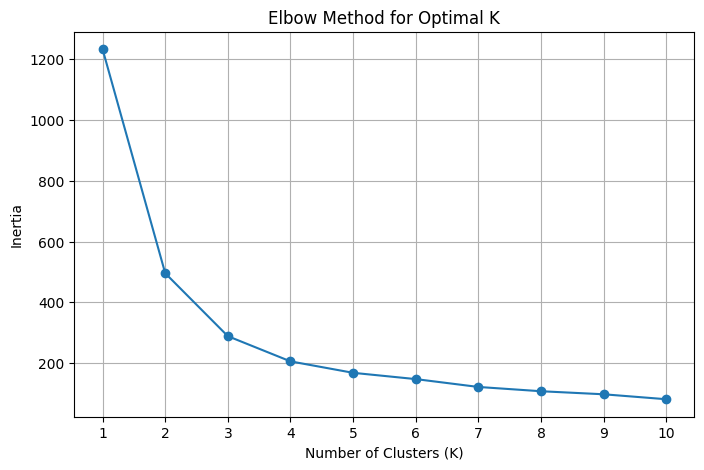

In [9]:
# Visualize the results of the elbow method

plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.xticks(k_values)
plt.grid(True)

plt.show()

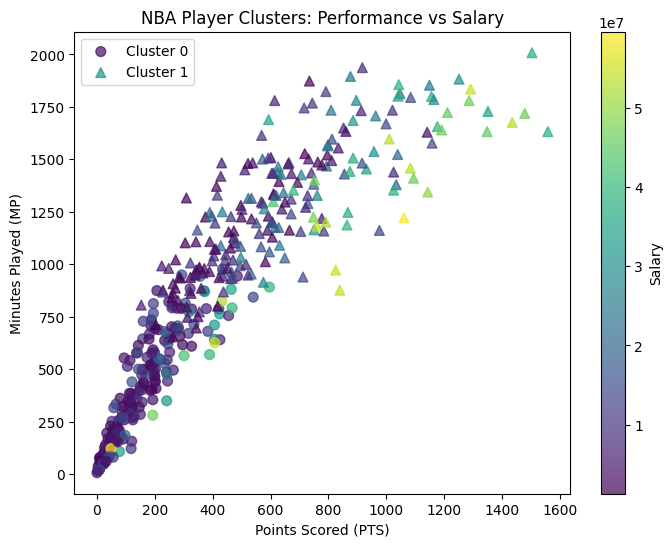

In [15]:
# Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

# Retrain KMeans with 2 clusters
kmeans_new = KMeans(n_clusters=2, random_state=42)
df["Cluster_2"] = kmeans_new.fit_predict(X_scaled)

# Relabel clusters by average points 
cluster_means_2 = df.groupby("Cluster_2")["PTS"].mean().sort_values()
cluster_map_2 = {old: new for new, old in enumerate(cluster_means_2.index)}
df["Cluster_2"] = df["Cluster_2"].map(cluster_map_2)

# Visualize clusters using two key performance variables
plt.figure(figsize=(8,6))

# Map clusters to markers/colors
markers = ['o', '^']
for cluster, marker in zip(sorted(df["Cluster_2"].unique()), markers):
    subset = df[df["Cluster_2"] == cluster]
    plt.scatter(
        subset["PTS"],
        subset["MP"],
        s=50,
        alpha=0.7,
        marker=marker,
        label=f"Cluster {cluster}",
        c=subset["Salary"], 
        cmap="viridis"
    )

plt.xlabel("Points Scored (PTS)")
plt.ylabel("Minutes Played (MP)")
plt.title("NBA Player Clusters: Performance vs Salary")
plt.legend()
plt.colorbar(label="Salary")
plt.show()

In [11]:
# Once again evaluate the quality of the clustering using total variance explained and silhouette scores

# Total sum of squares
overall_mean = np.mean(X_scaled, axis=0)
TSS = np.sum((X_scaled - overall_mean) ** 2)

# Within cluster sum of squares
WSS_k2 = kmeans_new.inertia_

# Total variance explained
variance_explained_k2 = 1 - (WSS_k2 / TSS)

print("Total Variance Explained:")
print(round(variance_explained_k2, 4))

# Silhouette Score
sil_score_k2 = silhouette_score(X_scaled, df["Cluster_2"])

print("\nSilhouette Score:")
print(round(sil_score_k2, 4))

Total Variance Explained:
0.5978

Silhouette Score:
0.4885


In [12]:
# Use the model to select players for Mr. Rooney to consider

# Convert salary to millions
df["Salary_millions"] = df["Salary"] / 1_000_000

# Performance metric: points per minute
df["PTS_per_MP"] = df["PTS"] / df["MP"]

# Value metric: efficiency relative to salary
df["Value"] = df["PTS_per_MP"] / df["Salary_millions"]

# Filter out very low minutes players
df_filtered = df[df["MP"] >= 300]

# Sort by cluster and value
df_sorted = df_filtered.sort_values(by=["Cluster", "Value"], ascending=[False, False])

not_good = df_sorted[df_sorted["Cluster"] == 0][["Player", "PTS", "MP", "Salary", "Value"]].head(4)
good = df_sorted[df_sorted["Cluster"] == 1][["Player", "PTS", "MP", "Salary", "Value"]].head(4)

# Potential backups: lower-value players from cluster 1 only
potential = df_sorted[df_sorted["Cluster"] == 1][["Player", "PTS", "MP", "Salary", "Value"]].tail(4)

print("Not Good Choices:\n", not_good)
print("\nGood Choices:\n", good)
print("\nPotential Backups:\n", potential)

Not Good Choices:
                       Player    PTS     MP     Salary     Value
8    Olivier-Maxence Prosper  185.0  398.0  1002360.0  0.463730
139           Nick Smith Jr.  146.0  318.0  2710680.0  0.169374
168             Cam Whitmore  193.0  354.0  3539760.0  0.154021
141            Liam McNeeley  115.0  342.0  2763960.0  0.121658

Good Choices:
              Player    PTS      MP     Salary     Value
11   Tyrese Proctor  191.0   404.0  1272870.0  0.371422
17   Maxime Raynaud  472.0  1127.0  1272870.0  0.329029
10  Mohamed Diawara  123.0   318.0  1272870.0  0.303874
15       Noah Penda  184.0   519.0  1272870.0  0.278526

Potential Backups:
               Player    PTS      MP      Salary     Value
440     Marcus Smart  433.0  1250.0  26720855.0  0.012964
461  Khris Middleton  372.0   869.0  33296296.0  0.012857
436   Draymond Green  397.0  1229.0  25892857.0  0.012476
501      Paul George  431.0   824.0  51666090.0  0.010124


In [13]:
# Write up the results in a separate notebook with supporting visualizations and 
# an overview of how and why you made the choices you did. This should be at least 
# 500 words and should be written for a non-technical audience.